# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### Imports

In [2]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow.keras.backend as keras_backend
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
# mpl.style.use('seaborn')
# from colorama import Fore
# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


In [3]:
# import functions for run
import model, train, train_maml
from sine_generator import SinusoidGenerator 
import generate_dataset, shuffled_batch 
from eval_sinewave_for_test import eval_sinewave_for_test
from  plot_model_comparison_to_average import plot_model_comparison_to_average
from  compare_maml_and_neural_net import compare_maml_and_neural_net
from save_model_weight import save_model_weight
from load_model_weight import load_model_weight 

colors = {0:'dodgerblue' , 1: 'tomato' , 2:'forestgreen'}

## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

# Generate sinusoid datasets


In [4]:
train_ds, test_ds = generate_dataset.generate_dataset(K=10, test_size=25)
train_ds[0]

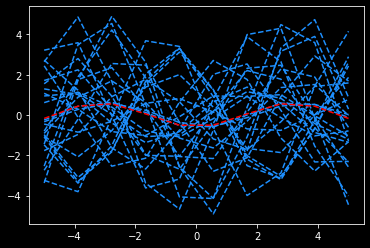

In [5]:
ts_ds = test_ds
# tr_ds, ts_ds = generate_dataset(K=10, test_size=25)
avg_pred =[]
x, _ = SinusoidGenerator(K=10).equally_spaced_samples()  
for i, sinusoid_generator in enumerate(ts_ds):
        _ , y = sinusoid_generator.equally_spaced_samples()
        plt.plot(x, y,'--', color=colors[0])
        avg_pred.append(y)
avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0),'--', color='red')
plt.show()

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [6]:
from model import SineModel

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

# Load Model

In [7]:

sinusoid_generator = SinusoidGenerator(K=10)
x, _ = sinusoid_generator.batch()
neural_net = load_model_weight(SineModel(), path="./net/neural_net_model", x=x)
maml = load_model_weight(SineModel(), path="./maml/maml_model", x=x)

print(neural_net.out.get_weights()[0].shape)
print(maml.out.get_weights()[0].shape)

(40, 1)
(40, 1)


### MAML vs Regular Neural Network

MAML


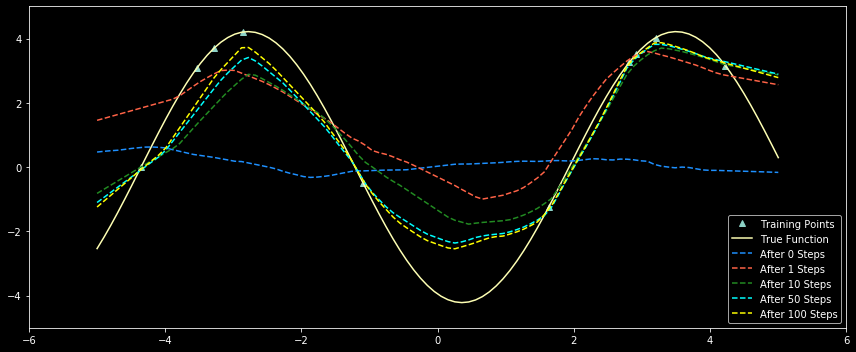

Neural Net


In [150]:
for _ in range(1):
    index = np.random.choice(range(len(test_ds)))
    w3_maml_model, w3_net_model, weight_gradient_net, weight_gradient_maml, loss_net, loss_maml\
                 = compare_maml_and_neural_net(maml, neural_net, test_ds[index])

In [135]:
sep = '='*30
out_grad_net = []
for key, grads in weight_gradient_net.items():
    print(f'\nkey: {key}\n hidden1(1,40)\n{grads[0]}\n{sep}\n hidden2(40,40)\n{grads[2]}\n{sep}\n out(40,1)\n{grads[4]}\n{sep}\n ')
    print('*='*40)
    out_grad_net.append(grads[4])



key: step1
 hidden1(1,40)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 hidden2(40,40)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 out(40,1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
 
*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

key: step10
 hidden1(1,40)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 hidden2(40,40)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 out(40,1)
[[0

In [136]:
out_grad_net

[<tf.Tensor: id=16403, shape=(40, 1), dtype=float64, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])>,
 <tf.Tensor: id=17119, shape=(40, 1), dtype=float64, numpy=
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [

In [137]:
sep = '='*30
out_grad_maml = []
for key, grads in weight_gradient_maml.items():
    print(f'\nkey: {key}\n hidden1(1,40)\n{grads[0]}\n{sep}\n hidden2(40,40)\n{grads[2]}\n{sep}\n out(40,1)\n{grads[4]}\n{sep}\n ')
    print('*='*40)
    out_grad_maml.append(grads[4])


key: step1
 hidden1(1,40)
[[  0.87573248   1.90202095   3.68975451   1.80434255  -1.92554778
    1.95643436  -1.43082816   2.26023531   0.90459143   1.75721148
   -0.58434719   0.43794765   3.57928858  -0.72313538  -0.88782892
    0.11342253  -1.16330961 -24.53282695   2.55271644  -3.58791701
    0.         -27.04394805  -0.12740861   0.36863265   5.50597778
   -0.32928131   1.96474783   3.06817001  16.82389572  -0.18261258
    7.52261147   0.           2.22317919   0.6290464   -1.45310014
   23.46558434   1.78015586  -0.33533396   0.88251514   0.13577817]]
 hidden2(40,40)
[[-0.59317621  0.35427379  0.         ...  0.          0.8044583
  -0.25168615]
 [ 0.          0.          0.10447635 ...  0.1722833   0.
  -0.06739141]
 [-0.3493174   0.2086294   0.         ...  0.          0.47071193
  -0.14671734]
 ...
 [ 0.          0.          0.         ...  0.          0.0217075
  -0.01074536]
 [ 0.          0.          0.24335171 ...  0.40129116  0.
  -0.10502146]
 [ 0.          0.          


bin:
 [-2.28336209 -2.0419553  -1.80054851 -1.55914171 -1.31773492 -1.07632813
 -0.83492134 -0.59351454 -0.35210775 -0.11070096  0.13070583]

 bin with most amount -0.11070095825392157

bin:
 [0.         0.14234649 0.28469298 0.42703947 0.56938597 0.71173246
 0.85407895 0.99642544 1.13877193 1.28111842 1.42346491]

 bin with most amount 0.2846929828165111


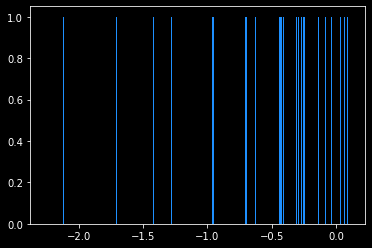

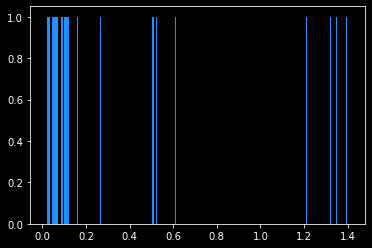

In [138]:

for i, grad in enumerate(out_grad_maml):
    fig = plt.figure(i)
    data = plt.hist(grad, facecolor='dodgerblue')
    # plt.xticks(np.linspace(-0.3,0.3,5))
    # plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    # print('n:\n', n,'\nbin:\n', bin_)
    print('\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

In [148]:
for key, loss in loss_net.items():
    print(f'\nkey: {key}\n {loss.numpy()}')


key: step1
 9.178411755851759

key: step10
 7.539646713624046


In [147]:
for key, loss in loss_maml.items():
    print(f'\nkey: {key}\n {loss.numpy()}')



key: step1
 8.435732454316147

key: step10
 1.044510360462716


# old

In [8]:
for i in range(len(w3_maml_model)):
    print(f'regular:\n {w3_net_model[i]}, \nmaml:\n{w3_maml_model[i]}')

regular:
 [[-2.26422462e-01]
 [ 3.15548797e-01]
 [ 4.71225043e-02]
 [-1.05756512e-02]
 [ 3.45126959e-04]
 [ 1.01409718e-01]
 [-1.58872847e-01]
 [-9.21971323e-02]
 [-1.36678230e-02]
 [-5.23611750e-02]
 [ 2.03296411e-04]
 [ 4.69504192e-02]
 [ 4.95054509e-02]
 [-1.82198098e-01]
 [ 1.70277432e-02]
 [ 3.11014479e-01]
 [-2.24632884e-01]
 [ 1.70937617e-01]
 [-1.18279907e-01]
 [ 2.21599097e-01]
 [-1.62286469e-02]
 [-3.24169538e-02]
 [-1.37922635e-02]
 [-4.72005110e-02]
 [ 2.11103207e-01]
 [ 1.34129435e-01]
 [-5.52768287e-02]
 [ 2.89479152e-01]
 [ 4.83618887e-02]
 [ 9.15804200e-02]
 [-3.20409112e-01]
 [-9.26264150e-02]
 [ 1.84734773e-01]
 [ 7.00020920e-02]
 [-1.56955526e-01]
 [ 1.78678623e-01]
 [ 3.72800747e-02]
 [ 1.72730695e-01]
 [-1.24366207e-01]
 [ 1.25795772e-01]], 
maml:
[[ 1.2415018 ]
 [-0.74148547]
 [-0.36077126]
 [-0.4296661 ]
 [ 0.5122649 ]
 [-0.2095407 ]
 [-0.0416024 ]
 [-0.78625483]
 [ 0.73357052]
 [-0.62644838]
 [-0.38382375]
 [-0.21099487]
 [-0.35799373]
 [ 0.40102399]
 [ 0.542034

# Difference of weights before fine-tuning and after

In [9]:
w3 = neural_net.out.get_weights()[0]
# print(neural_net.out.get_weights())
for i in range(len(w3_net_model)):

    print(f'regular:\n {w3 - w3_net_model[i]}')

regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [10]:
w3_maml = maml.out.get_weights()[0]
for i in range(len(w3_maml_model)):

    print(f'maml:\n {w3_maml - w3_maml_model[i]}')

maml:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
maml:
 [[ 0.00536334]
 [ 0.01423167]
 [-0.02236772]
 [-0.01313934]
 [-0.00879168]
 [-0.01880503]
 [ 0.        ]
 [-0.00532195]
 [-0.01263932]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00264826]
 [-0.01913598]
 [-0.02734245]
 [ 0.01526443]
 [ 0.00912933]
 [ 0.00888914]
 [-0.00199451]
 [ 0.00240543]
 [-0.00397975]
 [ 0.01069797]
 [-0.0093179 ]
 [-0.01577028]
 [-0.0014041 ]
 [ 0.0115097 ]
 [ 0.01134322]
 [ 0.        ]
 [-0.00080783]
 [-0.01365802]
 [-0.01195412]
 [ 0.        ]
 [-0.00169401]
 [ 0.00803956]
 [-0.00116743]
 [ 0.        ]
 [ 0.01378944]
 [-0.02436604]
 [ 0.        ]
 [-0.00405568]]
maml:
 [[-0.02913045]
 [ 0.07203819]
 [-0.02092401]
 [-0.00854394]
 [-0.01555809]
 [-0.01664029]
 [ 0.        ]
 [-0.00028906]
 [-0.0278909 ]
 [

n:
 [1. 5. 5. 8. 4. 4. 6. 5. 1. 1.] 
bin:
 [-1.08783055 -0.85489731 -0.62196408 -0.38903084 -0.15609761  0.07683562
  0.30976886  0.54270209  0.77563533  1.00856856  1.2415018 ]

 bin with most amount -0.3890308449719253
n:
 [1. 4. 6. 8. 4. 3. 6. 6. 1. 1.] 
bin:
 [-1.09695987 -0.86365004 -0.63034021 -0.39703037 -0.16372054  0.06958929
  0.30289913  0.53620896  0.76951879  1.00282863  1.23613846]

 bin with most amount -0.3970303739967409
n:
 [ 1.  4.  4. 10.  4.  2.  7.  7.  0.  1.] 
bin:
 [-1.15379542 -0.91135265 -0.66890988 -0.42646712 -0.18402435  0.05841841
  0.30086118  0.54330395  0.78574671  1.02818948  1.27063225]

 bin with most amount -0.426467118155351


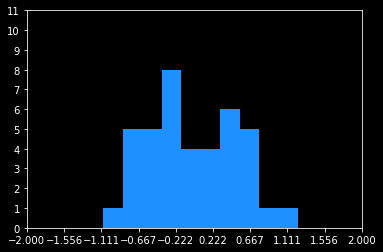

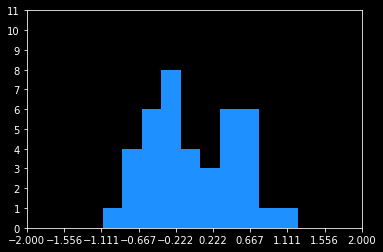

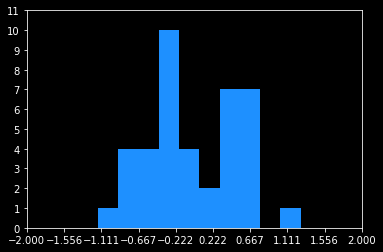

In [11]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml_model[i], facecolor='dodgerblue')
    plt.xticks(np.linspace(-2,2,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

n:
 [ 0.  0.  0.  0.  0. 40.  0.  0.  0.  0.] 
bin:
 [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]

 bin with most amount 0.0
n:
 [ 2.  2.  2.  4.  2.  5. 13.  1.  4.  5.] 
bin:
 [-0.02734245 -0.02308176 -0.01882108 -0.01456039 -0.0102997  -0.00603901
 -0.00177833  0.00248236  0.00674305  0.01100374  0.01526443]

 bin with most amount -0.0017783251289707792
n:
 [ 4.  4.  9. 13.  2.  2.  0.  2.  2.  2.] 
bin:
 [-0.04085494 -0.02956563 -0.01827631 -0.006987    0.00430231  0.01559162
  0.02688094  0.03817025  0.04945956  0.06074887  0.07203819]

 bin with most amount -0.00698700129322373


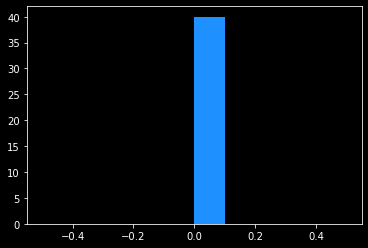

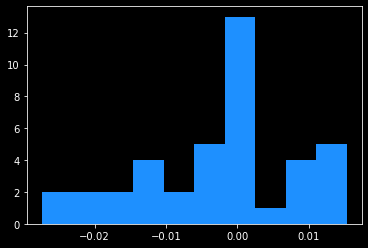

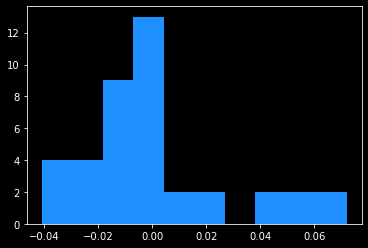

In [12]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml - w3_maml_model[i], facecolor='dodgerblue')
#     plt.xticks(np.linspace(-0.1,0.1,10))
#     plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

![alt text](https://miro.medium.com/max/585/1*WmG_R90SyXjWwu6qPfwtQQ.png)